## 波的相加

In [1]:
import numpy as np
import copy
from matplotlib import pyplot as plt

%matplotlib widget

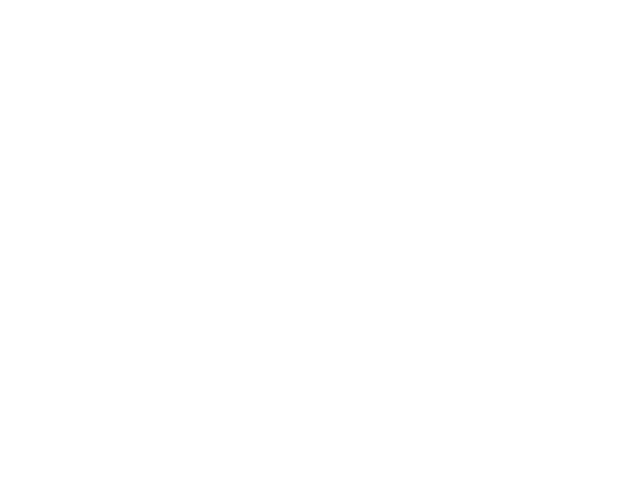

In [3]:
class SineWave:
    def __init__(self, A=1, limu=0, limd=80, res=1000, i=1, k=2, w=2):
        self.x = np.linspace(limu, limd, res)
        self.y = None
        self.A = A
        self.i = i
        self.k = k
        self.w = w

    def __add__(self, other):
        if isinstance(other, SineWave):
            _o = copy.copy(self)
            _o.y = _o + other.y
            return _o
        elif isinstance(other, np.ndarray):
            return other + self.y
        else:
            raise TypeError("")

    def subs(self, t):
        self.y = self.A * np.sin(self.i * (self.k * self.x - self.w * t))

    def plot(self, color="gray"):
        plt.plot(self.x, self.y, color=color)

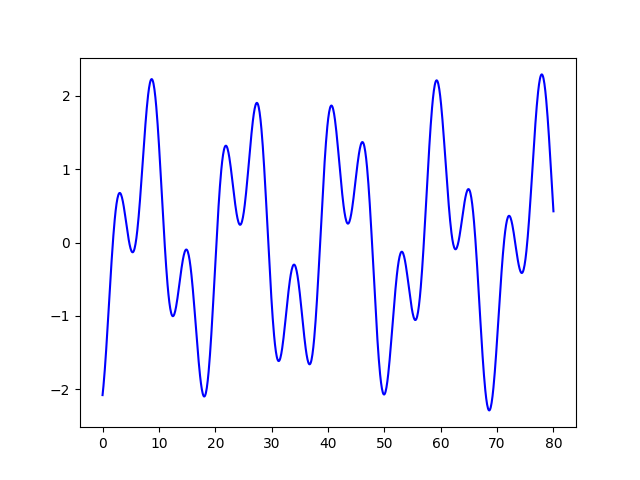

In [4]:
plt.clf()

w1 = SineWave(A=1, i=1, k=1, w=1)
w2 = SineWave(A=1.3, i=1.8, k=0.2, w=0.7)
# w3 = SineWave(A=1.7, i=2.6, k=1.4, w=0.2)
w1.subs(1)
w2.subs(1)
# w3.subs(0)
# w1.plot()
# w2.plot()
# w3.plot()
a = w1+w2  # +w3
a.plot(color="blue")

plt.show()

## 波包檢測

### 載入函式庫
1. numpy: 資料處理
2. matplotlib: 繪圖
3. scipy: 訊號處理, hilbert是使用希爾伯特轉換計算解析訊號

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

### 設定參數
t是時間軸, 代表0~1秒, 共400(num_samples)個點

In [4]:
duration = 1.0  # 資料時間長度
s_rate = 400.0  # 解析度, Hz
num_samples = int(s_rate * duration)  # 資料點數
t = np.linspace(0., duration, num_samples)  # 時間軸

### 產生訊號
調變訊號 = 載波訊號 * 原始訊號

In [ ]:
carrier_signal = np.sin(2. * np.pi * 30. * t)  # 載波訊號
original_signal = 3 + 0.7 * np.sin(2. * np.pi * 3. * t)  # 原始訊號
signal = carrier_signal * original_signal  # 調變訊號

### 訊號解調
希爾伯特轉換: 將訊號轉換成複數, 並取其實部
$\mathcal{H}(s(t))$是$s(t)$的希爾伯特轉換
$s(t)$的解析訊號為$\tilde{s}(t)$，用希爾伯特轉換表示為:
$$\tilde{s}(t)=s(t)+i\mathcal{H}(s(t))$$
以cos為例:
$$\mathcal{H}(\cos(2\pi ft))=\cos\left(2\pi ft-\frac{\pi}{2}\right)=\sin(2\pi ft)$$
其解析訊號為:
$$\tilde{s}(t)=\cos(2\pi ft)+i\sin(2\pi ft)=e^{i2\pi ft}$$
依據scipy的官方文件，scipy的hilbert代表將訊號轉換為解析訊號，使用希爾伯特轉換。
其公式為:
$$\tilde{s}(t)=F^{-1}(F(s(t)) 2U) = s(t) + i \mathcal{H}(s(t))$$
其中$F$為傅立葉轉換，$U$為單位階躍函數。
而其包絡$R(t)$為解析訊號的幅度:
$$R(t)=\left|\tilde{s}(t)\right|=\sqrt{s(t)^2+\mathcal{H}(s(t))^2}$$

In [5]:
analytic_signal = hilbert(signal)  # 計算解析訊號
amplitude_envelope = np.abs(analytic_signal)  # 振幅包絡

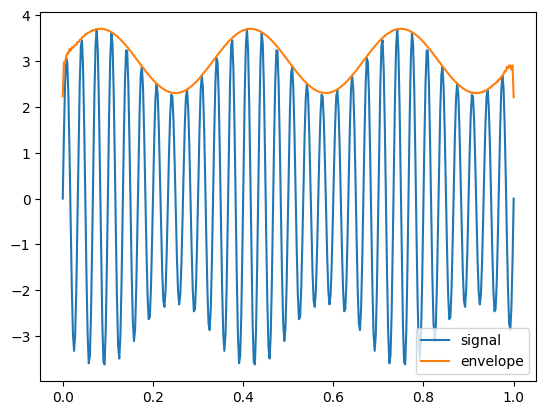

In [8]:
plt.clf()  # 清除畫布
plt.plot(t, signal, label='signal')  # 繪製訊號
plt.plot(t, amplitude_envelope, label='envelope')  # 繪製包絡
plt.legend(loc="best")  # 顯示圖例
plt.show()  # 顯示結果